In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
from pyLDAvis import gensim_models 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import os
import sys
import ast
from textblob import TextBlob
import string
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime



In [4]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [41]:
organic_food_reddit = pd.read_csv('organic food headlines.csv', sep=',', index_col= None) \
    .drop(columns='Unnamed: 0')

# organic_food_reddit.sample(2)

In [42]:
# Extract exact dates

old_dates = organic_food_reddit['created']

date_time = [datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S') for date in old_dates]

date = pd.to_datetime(date_time)

organic_food_reddit['date'] = date.date
organic_food_reddit = organic_food_reddit.drop(columns='created').drop_duplicates()
# organic_food_reddit.sample(2)

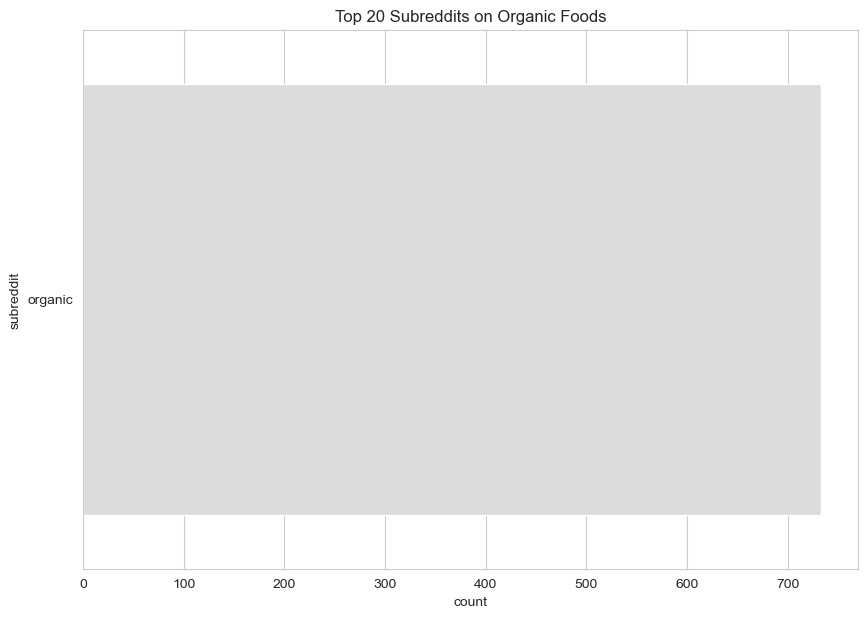

In [43]:
# Subreddits Descriptive Stats
sns.set_style('whitegrid')
subreddits = organic_food_reddit['subreddit'].value_counts().sort_values(ascending=False).head(20).reset_index()
subreddits.shape
plt.figure(figsize=(10,7))
plt.title("Top 20 Subreddits on Organic Foods")
sns.barplot(subreddits, x='count', y='subreddit', errorbar='sd', palette='coolwarm')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


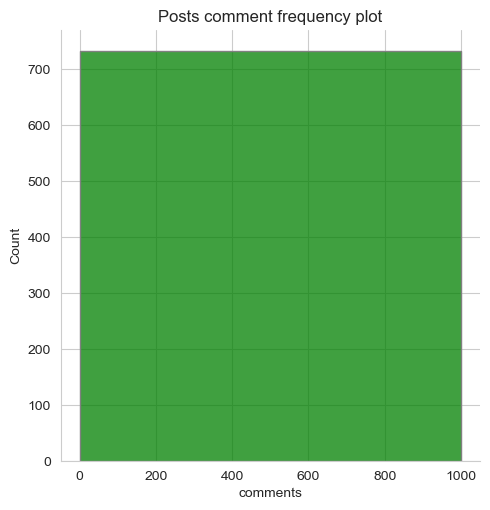

In [44]:
# Content comments / votes distribution

sns.displot(
    data=organic_food_reddit, 
    x='comments', 
    binwidth = 1000, 
    color= 'green', 
    edgecolor= 'gray')
plt.title('Posts comment frequency plot')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


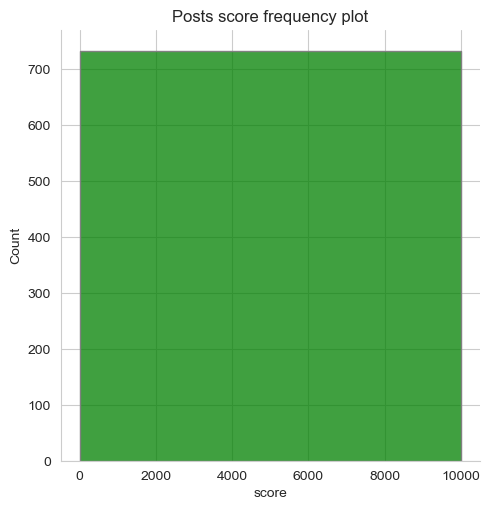

In [45]:
# Content score / votes distribution

sns.displot(
    data=organic_food_reddit, 
    x='score', 
    binwidth = 10000, 
    color= 'green', 
    edgecolor= 'gray')
plt.title('Posts score frequency plot')
plt.show()

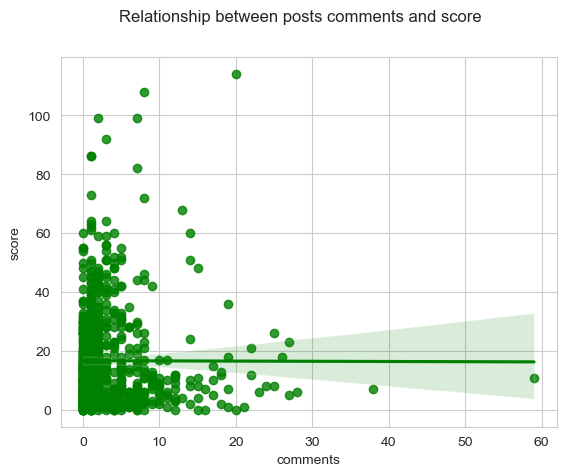

In [46]:
sns.set_style('whitegrid')
sns.regplot(organic_food_reddit, x='comments', y='score', color='green')
plt.suptitle('Relationship between posts comments and score')
plt.show()

In [47]:
# Handle words contractions

def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s" : " is",
        "'d" : " would",
        "'ve" : " have",
        "'re": " are",
        "'ll": " will",
        "'m": " am"
    }
    
    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)


In [83]:
# Preprocess text, remove stopwords, tokenize and Lemmatize

def preprocess_text(text, freq_words=False):
    text = text.lower()
    
    ## remove numbers from the text
    text = re.sub(r"\d+", '', text)
    
    ## removing punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    ## Tokenize text
    tokens = word_tokenize(text)
    
    ## Remove stopwords
    stop_words = stopwords.words("english")
    if freq_words:
        stop_words.extend(['organic', '“', '’', '”', '‘'])
    tokens = [token for token in tokens if token not in stop_words]
    
    ## Remove contractions from words
    text = handle_contractions(' '.join(tokens))
    
    ## Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    
    return ' '.join(tokens)


In [84]:
filtered_df = organic_food_reddit[organic_food_reddit['body'].notnull()]
organic_food_reddit['cleaned_title'] = organic_food_reddit['title'].apply(preprocess_text)

,title,subreddit,score,id,url,comments,body,upvotes,downvotes,date,cleaned_title
0,In need of affordable organic clothing,organic,4,17lkj0k,https://www.reddit.com/r/organic/comments/17lk...,2,I want to update my wardrobe with all organic ...,4,0,2023-11-01,need affordable organic clothing
5,What Grocery Store Chicken Is ACTUALLY Good?,organic,2,16ldhqd,https://www.reddit.com/r/organic/comments/16ld...,7,"Eating clean, non-steroid and chemical pumped ...",2,0,2023-09-17,grocery store chicken actually good
7,Is anyone mostly an organic guy/gal not becaus...,organic,8,1634fxn,https://www.reddit.com/r/organic/comments/1634...,9,You think wild food is the best but organic is...,8,0,2023-08-27,anyone mostly organic guygal think know gmos b...
8,USDA ORGANIC Certification Must Be Amended To ...,organic,17,1632uub,https://www.reddit.com/r/organic/comments/1632...,2,Has there been any organizing with amending th...,17,0,2023-08-27,usda organic certification must amended ensure...
12,Organic labeling: what you need to know.,organic,2,15mqbo6,https://www.reddit.com/r/organic/comments/15mq...,0,Organic labeling: what you need to know.\n\nTh...,2,0,2023-08-09,organic labeling need know
...,...,...,...,...,...,...,...,...,...,...,...
715,Organic fish and meat recommendations?,organic,3,fr8eav,https://www.reddit.com/r/organic/comments/fr8e...,12,Hi there!\n\nI’ve developed some health proble...,3,0,2020-03-29,organic fish meat recommendation
723,"Exterior wood treatment, what do you use?",organic,6,fij3ip,https://www.reddit.com/r/organic/comments/fij3...,5,I'm aiming to make trellis for raspberries and...,6,0,2020-03-14,exterior wood treatment use
726,Eggs,organic,2,fhjg70,https://www.reddit.com/r/organic/comments/fhjg...,6,"Hello,\n\n&#x200B;\n\nMy wife and I were at th...",2,0,2020-03-12,egg
728,College Survey,organic,2,ffy7op,https://www.reddit.com/r/organic/comments/ffy7...,5,Hello all! I am working on a class project wit...,2,0,2020-03-09,college survey


In [85]:
# Calculate sentiments

def percentage(val, total):
    return (val / total) * 100

# Sentiment Scores
def get_sentiment_scores(text_array):
    
    positive = 0
    negative = 0
    neutral = 0

    scores = []

    content_list = []

    positive_list = []
    negative_list = []
    neutral_list = []

    contents = text_array
    
    subjectivity_score = contents.apply(lambda x: TextBlob(x).sentiment.subjectivity)
    polarity_score = contents.apply(lambda x: TextBlob(x).sentiment.polarity)

    for content in contents:
        #print(content)
        content_list.append(content)
        score = SentimentIntensityAnalyzer().polarity_scores(content)
        neg_score = score['neg']
        pos_score = score['pos']
        neu_score = score['neu']    
        
        scores.append([neg_score, pos_score, neu_score])
        
        if neg_score > pos_score:
            negative_list.append(content)
            negative += 1
        elif neg_score < pos_score:
            positive_list.append(content)
            positive += 1
        elif neg_score == pos_score:
            neutral_list.append(content)
            neutral += 1
            
    positive = percentage(positive, len(contents))
    negative = percentage(negative, len(contents))
    neutral = percentage(neutral, len(contents))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')
    
    
    return {
        'polarity': polarity_score,
        'subjectivity': subjectivity_score,
        'scores': scores,
        'positive': positive,
        'negative': negative,
        'neutral' : neutral
    }

In [86]:
# get sentiment scores
all_scores = get_sentiment_scores(organic_food_reddit['cleaned_title'])

# add sentiment scores to dataframe
organic_food_reddit_scores = organic_food_reddit.reset_index()\
    .merge(pd.DataFrame(all_scores['scores'], columns=["neg", "pos", "neu"]).reset_index())

# add polarity and subjectivity scores to dataframe
organic_food_reddit_scores['polarity'] = all_scores['polarity']
organic_food_reddit_scores['subjectivity'] = all_scores['subjectivity']

# percentages of positive, negative and neutral
positive = all_scores['positive']
negative = all_scores['negative']
neutral = all_scores['neutral']

# attach sentiment scores
organic_food_reddit_scores.loc[organic_food_reddit_scores['neg'] > organic_food_reddit_scores['pos'], "sentiment_label"] = "negative"
organic_food_reddit_scores.loc[organic_food_reddit_scores['pos'] > organic_food_reddit_scores['neg'], "sentiment_label"] = "positive"
organic_food_reddit_scores.loc[organic_food_reddit_scores['neg'] == organic_food_reddit_scores['pos'], "sentiment_label"] = "neutral"

organic_food_reddit_scores.sample(2)

,index,title,subreddit,score,id,url,comments,body,upvotes,downvotes,date,cleaned_title,neg,pos,neu,polarity,subjectivity,sentiment_label
34,34,USDA’s new steps to support organic producers,organic,13,13s7gm4,https://www.reddit.com/r/organic/comments/13s7...,5,USDA’s new steps to support organic producers ...,13,0,2023-05-26,usda ’ new step support organic producer,0.0,0.351,0.649,0.136364,0.454545,positive
247,247,Organic Fertilizer by Composting at Home,organic,3,qhwpbx,https://youtu.be/nvv2qA6gRQ8,0,NaN,3,0,2021-10-28,organic fertilizer composting home,0.0,0.000,1.000,0.000000,0.000000,neutral


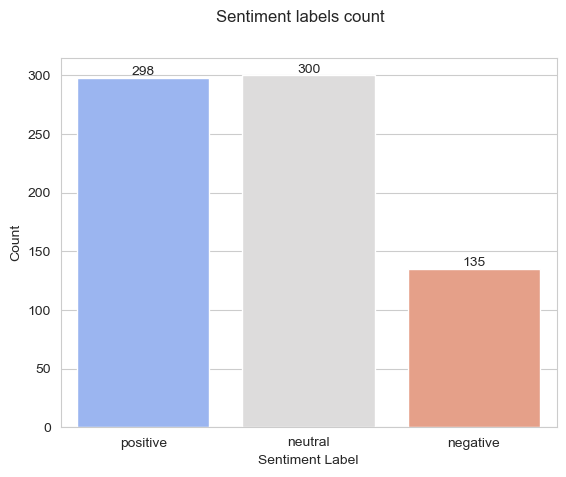

In [87]:
# sentiment labels barplot

plt.suptitle('Sentiment labels count')
sns.set_style('whitegrid')
ax = sns.countplot(data=organic_food_reddit_scores, x="sentiment_label", palette='coolwarm', order=['positive', 'neutral', 'negative'])
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [244]:
cv = [date.strftime("%B %Y") for date in organic_food_reddit_scores['date']]

organic_food_reddit_scores['year'] = cv

In [257]:

neg_reddit = organic_food_reddit_scores[organic_food_reddit_scores['sentiment_label'] == "negative"]
pos_reddit = organic_food_reddit_scores[organic_food_reddit_scores['sentiment_label'] == "positive"]
neu_reddit = organic_food_reddit_scores[organic_food_reddit_scores['sentiment_label'] == "neutral"]

neg_reddit = neg_reddit[['year','sentiment_label']].groupby("year").count()
pos_reddit = pos_reddit[['year','sentiment_label']].groupby("year").count()
# neu_five_g = neu_five_g[['year','sentiment_label']].groupby("year").count()


In [265]:
ng = neg_reddit.reset_index()

def custom_key(date_str):
    return datetime.strptime(date_str, "%B %Y")
    

# sorted_dates = sorted(date_str_list, key=custom_key)
ng['year'] = ng['year'].map(custom_key)  # Convert 'year' to yeartime objects
ng = ng.sort_values(by='year').reset_index(drop=True)  # Sort by 'year' and reset the index

# Convert 'year' back to the "Month Year" format
ng['year'] = ng['year'].dt.strftime('%B %Y')

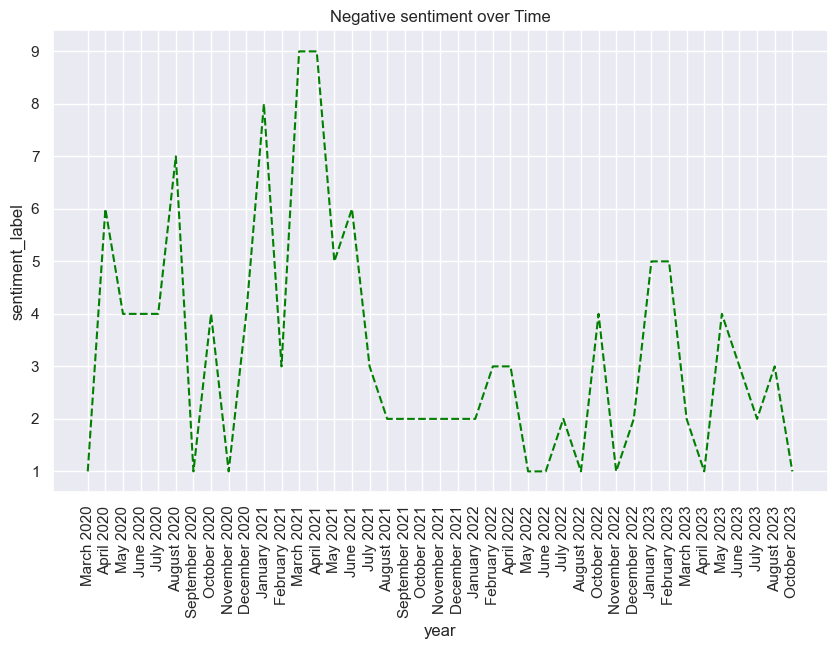

In [273]:
plt.figure(figsize=(10, 6))
plt.title("Negative sentiment over Time")
sns.lineplot(
    data=ng,
    x="year", y="sentiment_label",
    markers=True, dashes=False,
    linestyle = "dashed",
    color = 'green'
)
plt.xticks(rotation=90)
plt.show()

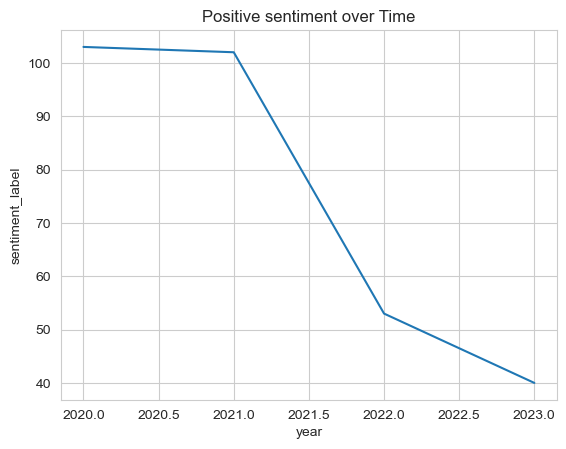

In [90]:
plt.title("Positive sentiment over Time")
sns.lineplot(
    data=pos_reddit,
    x="year", y="sentiment_label",
    markers=True, dashes=False
)
plt.show()

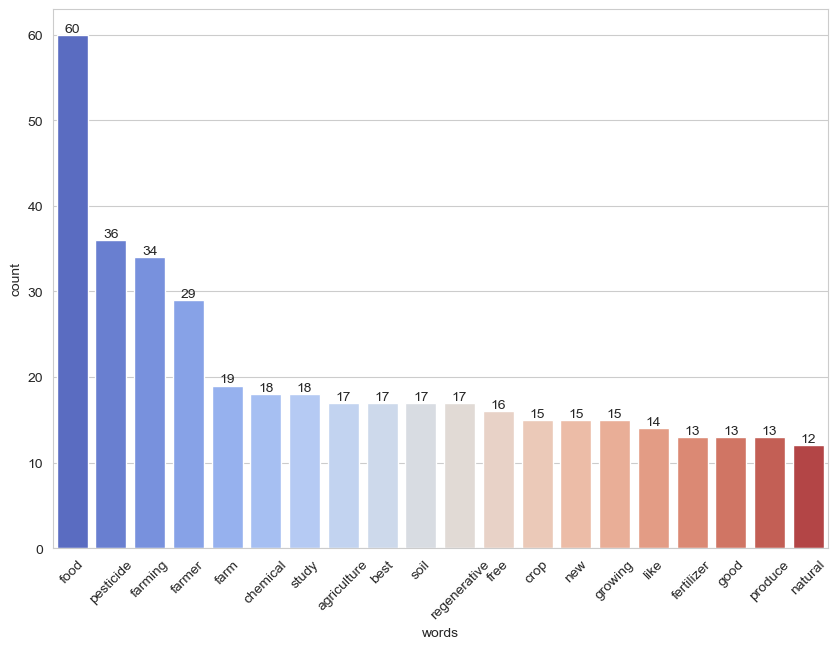

In [91]:
# word frequency for positive sentiments

positive_df = organic_food_reddit_scores.loc[organic_food_reddit_scores['sentiment_label'] == 'positive']['cleaned_title']
positive_words = " ".join(positive_df.apply(preprocess_text, freq_words = True))
words_count = Counter(positive_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

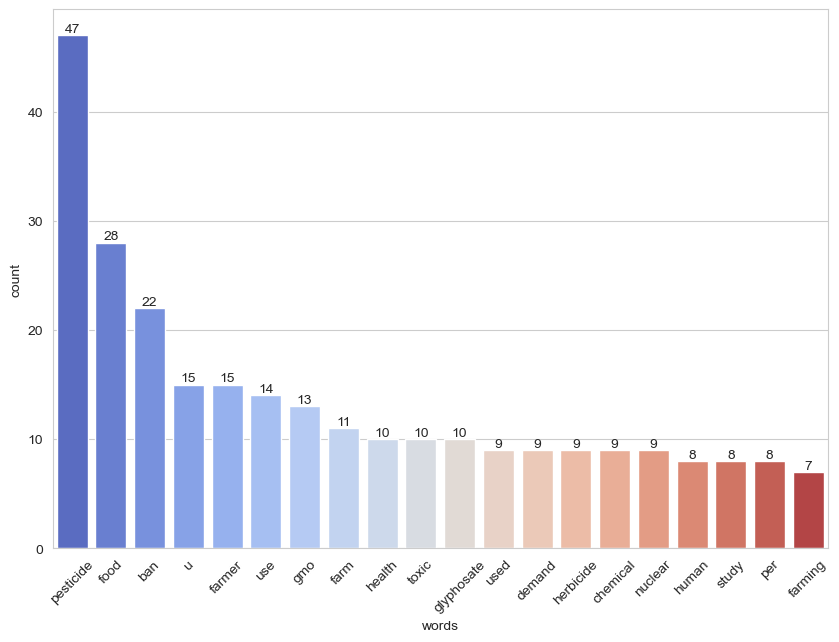

In [92]:
negative_df = organic_food_reddit_scores.loc[organic_food_reddit_scores['sentiment_label'] == 'negative']['cleaned_title']
negative_words = " ".join(negative_df.apply(preprocess_text, freq_words = True))
words_count = Counter(negative_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


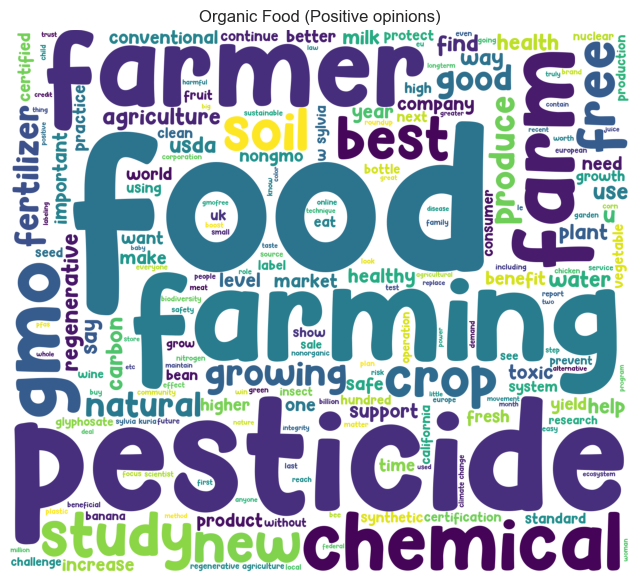

In [110]:
wordcloud_positive = WordCloud(
    background_color='white',
    max_words=200,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(positive_words)

plt.figure(figsize=(8,15))
plt.imshow(wordcloud_positive)
plt.title("Organic Food (Positive opinions)")
plt.axis('off')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


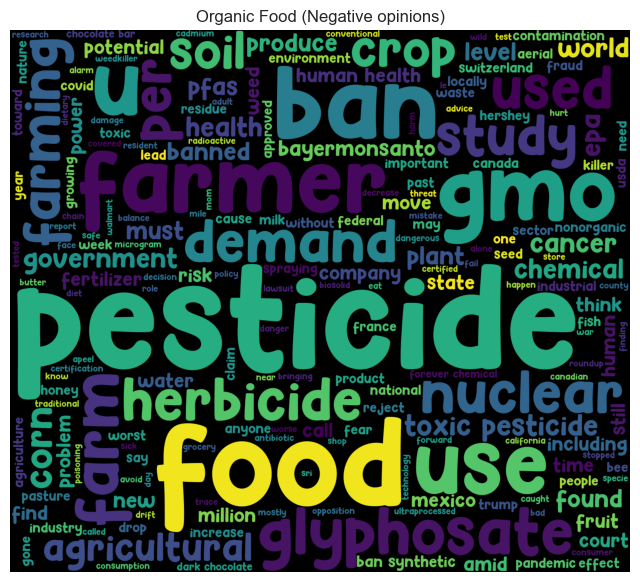

In [112]:
wordcloud_negative = WordCloud(
    background_color='black',
    max_words=200,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(negative_words)

plt.figure(figsize=(8,15))
plt.imshow(wordcloud_negative)
plt.title("Organic Food (Negative opinions)")
plt.axis('off')
plt.show()

### Bag of words model

In order to use text as an input to machine learning algorithms, we need to present it in a numerical format. Bag-of-words is a vector space model and represents the occurrence of words in the document. In other words, bag-of-words converts each review into a collection of word counts without giving importance to the order or meaning.

In [95]:
# Bag of words model

# create dictionary
organic_food_reddit_scores['cleaned_title_list'] = [list(sent.split()) for sent in organic_food_reddit_scores['cleaned_title'].apply(preprocess_text, freq_words = True)]
id2word = gensim.corpora.Dictionary(organic_food_reddit_scores['cleaned_title_list'])

corpus = [id2word.doc2bow(text) for text in organic_food_reddit_scores['cleaned_title_list']]

In [96]:
unique_words = set()
for doc in corpus:
    unique_words.update([term for term, _ in doc])
num_unique_words = len(unique_words)

num_documents = len(corpus)

# Print the results
print("Number of unique words (terms):", num_unique_words)
print("Number of documents in the corpus:", num_documents)

Number of unique words (terms): 2583
Number of documents in the corpus: 733


### Determining the Number of Topics
Deciding on the number of topics for the topic modeling can be difficult. Since we have initial knowledge of the context, determining the number of topics for modeling wouldn't be too outraging. However, if this number is too much then the model might fail to detect a topic that is actually broader and if this number is too less then topics might have large overlapping words. Because of these reasons, we will use the topic coherence score.

In [136]:
# Using coherence model to determine the number of topics

num_topics = []
coherence_score = []

text = organic_food_reddit_scores['cleaned_title_list']

for i in range(1, 10):
    lda_model = LdaModel(corpus=corpus, id2word = id2word, iterations = 50, num_topics = i)
    coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    num_topics.append(i)
    coherence_score.append(coherence_lda)
    
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics': num_topics,
                                'coherence_score': coherence_score})



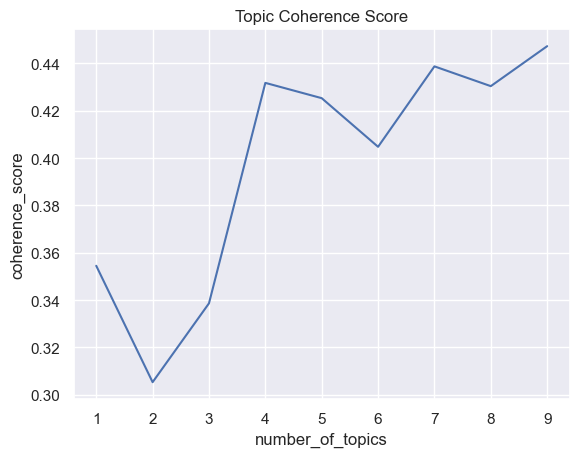

In [137]:
sns.set_theme()

sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(title = "Topic Coherence Score")
plt.show()

A very high coherence score is achieved with just 3 topics, then we will construct our LDA model with just 3 topics.

In [188]:
# Topic modelling with LDA

# number of topics
n_topics = 9

# lda_model = LdaModel(
#     corpus=corpus, 
#     id2word=id2word, 
#     num_topics=n_topics
#     # random_state=100, 
#     # update_every=1, 
#     # chunksize=10,
#     # passes=10,
#     # alpha='symmetric',
#     # iterations=100,
#     # per_word_topics=True
# )
lda_model = LdaModel(
    corpus=corpus, 
    id2word = id2word, 
    iterations = 100, 
    num_topics = i,
    # per_word_topics=True,
    update_every=1,
    random_state=100,
    passes =10,
    alpha='symmetric',
    chunksize=10
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} Word: {topic}")


Topic: 0 Word: 0.100*"farm" + 0.036*"demand" + 0.035*"use" + 0.024*"health" + 0.015*"environmental" + 0.015*"milk" + 0.013*"compost" + 0.013*"banned" + 0.013*"gone" + 0.012*"human"
Topic: 1 Word: 0.044*"delivery" + 0.043*"meal" + 0.042*"u" + 0.038*"water" + 0.028*"corn" + 0.016*"kit" + 0.013*"dirty" + 0.013*"dozen" + 0.012*"federal" + 0.012*"report"
Topic: 2 Word: 0.058*"produce" + 0.056*"farming" + 0.037*"gmo" + 0.036*"seed" + 0.025*"usda" + 0.024*"way" + 0.021*"guide" + 0.019*"new" + 0.015*"come" + 0.015*"small"
Topic: 3 Word: 0.052*"per" + 0.032*"glyphosate" + 0.024*"soil" + 0.019*"system" + 0.018*"treatment" + 0.017*"weed" + 0.016*"safety" + 0.014*"regenerative" + 0.014*"herbicide" + 0.013*"practice"
Topic: 4 Word: 0.041*"sylvia" + 0.039*"w" + 0.035*"service" + 0.033*"garden" + 0.028*"kuria" + 0.018*"need" + 0.017*"looking" + 0.017*"egg" + 0.017*"free" + 0.016*"consumer"
Topic: 5 Word: 0.080*"farmer" + 0.073*"pesticide" + 0.035*"acre" + 0.024*"using" + 0.023*"year" + 0.021*"chemica

In [190]:
coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
coherence_scores = coherence_model.get_coherence_per_topic()

# coherence_scores = coherence_model.get_coherence_per_topic()
for topic, coherence_score in enumerate(coherence_scores):
    print(f"Topic {topic + 1}: Coherence Score = {coherence_score:.4f}")


Topic 1: Coherence Score = 0.5919
Topic 2: Coherence Score = 0.5875
Topic 3: Coherence Score = 0.5600
Topic 4: Coherence Score = 0.5584
Topic 5: Coherence Score = 0.5837
Topic 6: Coherence Score = 0.5529
Topic 7: Coherence Score = 0.5963
Topic 8: Coherence Score = 0.6193
Topic 9: Coherence Score = 0.6690


In [209]:

# Print the words in each topic for the LDA model
topics = lda_model.print_topics(num_topics=n_topics, num_words=10)


for topic_id, topic_str in topics:
    # Split the topic string on ' + ' to separate words and probabilities
    topic_words = topic_str.split(' + ')
    print(f"Topic {topic_id + 1}:")
    
    # Extract and print just the words
    for word_prob in topic_words:
        word = word_prob.split('*')[1].strip('" ')
        print(word, end=' ')
    print('\n')


Topic 1:
farm demand use health environmental milk compost banned gone human 

Topic 2:
delivery meal u water corn kit dirty dozen federal report 

Topic 3:
produce farming gmo seed usda way guide new come small 

Topic 4:
per glyphosate soil system treatment weed safety regenerative herbicide practice 

Topic 5:
sylvia w service garden kuria need looking egg free consumer 

Topic 6:
farmer pesticide acre using year chemical crop industry important ban 

Topic 7:
food rise plant safe sale make work acreage spread pathogen 

Topic 8:
help covid say could growing pandemic production online best healthy 

Topic 9:
meat survey coronavirus agriculture people next end industrial feed college 



In [192]:
document_topic_distribution = [lda_model[doc] for doc in corpus]

# Create a list to store the document IDs associated with each topic
documents_by_topic = [[] for _ in range(lda_model.num_topics)]

# Assign documents to topics
for document_id, topic_distribution in enumerate(document_topic_distribution):
    for topic_id, topic_probability in topic_distribution:
        documents_by_topic[topic_id].append(document_id)

# Print the list of document IDs associated with each topic
for topic_id, document_ids in enumerate(documents_by_topic):
    print(f"Topic {topic_id + 1} - Number of Documents: {len(document_ids)}")
    print("Document IDs:", document_ids)
    print()


Topic 1 - Number of Documents: 647
Document IDs: [0, 2, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 79, 80, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 116, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 145, 146, 147, 149, 150, 151, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 

In [193]:
from gensim.models import LdaModel
from gensim import corpora

# Assuming you have already trained your LDA model and have a corpus and id2word
# lda_model = LdaModel.load("your_model_file_path")  # Load your LDA model
top_id = []
top_pr = []
# Get the topic distribution for each document in the corpus
document_topic_distribution = [lda_model[doc] for doc in corpus]

# Create a data structure to map documents to their associated topics
documents_with_topics = {document_id: [] for document_id in range(len(corpus))}

# Assign topics to documents
for document_id, topic_distribution in enumerate(document_topic_distribution):
    for topic_id, topic_probability in topic_distribution:
        documents_with_topics[document_id].append((topic_id, topic_probability))

# Print documents with their associated topics
for document_id, associated_topics in documents_with_topics.items():
    # print(f"Document {document_id + 1}:")
    top_maps = []
    for topic_id, topic_probability in associated_topics:
        mapped_tt = (topic_id, topic_probability)
        top_maps.append(mapped_tt)

    key_with_max_value = max(top_maps, key=lambda x: x[1])
    _ = key_with_max_value[0]
    top_id.append(_)
    top_pr.append(key_with_max_value[1])    

    


In [195]:
organic_food_reddit_scores["topic_id"] = top_id
organic_food_reddit_scores["topic_probability"] = top_pr


In [238]:

topic_sentiments = organic_food_reddit_scores[['polarity','subjectivity','topic_id','topic_probability','upvotes','downvotes']]
topic_sentiments = topic_sentiments.groupby('topic_id').mean().reset_index()



topic_sentiments['topic_id'] = list(range(1,10))
print(topic_sentiments)

   topic_id  polarity  subjectivity  topic_probability    upvotes  downvotes
0         1  0.045004      0.237821           0.522823  19.082192        0.0
1         2  0.075833      0.195297           0.515133  18.000000        0.0
2         3  0.042795      0.259921           0.551296  12.898876        0.0
3         4  0.085168      0.271608           0.509854  24.914634        0.0
4         5  0.054595      0.233439           0.538223  10.011236        0.0
5         6  0.096662      0.290279           0.553817  25.881720        0.0
6         7  0.102639      0.266438           0.506390  16.831325        0.0
7         8  0.119003      0.320735           0.563962   9.762500        0.0
8         9  0.047830      0.205002           0.462984  13.300000        0.0


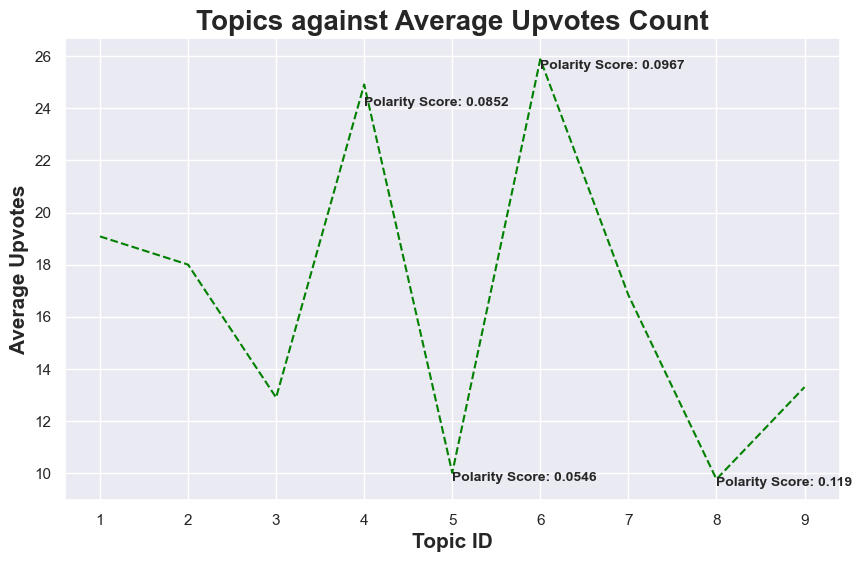

In [287]:
# sns.set(style="whitegrid")
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(x="topic_id", y="upvotes", data=topic_sentiments, linestyle='dashed', color='green')

plt.title("Topics against Average Upvotes Count",fontweight='bold', fontsize='20')
plt.xlabel("Topic ID", fontweight='bold', fontsize='15')
plt.ylabel("Average Upvotes",fontweight='bold', fontsize='15')
plt.text(6, 25.5, f"Polarity Score: {round(topic_sentiments['polarity'][5],4)}", fontsize=10, fontweight="bold")
plt.text(8, 9.5, f"Polarity Score: {round(topic_sentiments['polarity'][7],4)}", fontsize=10, fontweight="bold")
plt.text(4, 24.1, f"Polarity Score: {round(topic_sentiments['polarity'][3],4)}", fontsize=10, fontweight="bold")
plt.text(5, 9.7, f"Polarity Score: {round(topic_sentiments['polarity'][4],4)}", fontsize=10, fontweight="bold")


# plt.legend(title="topic_probability", loc="upper left")
plt.show()

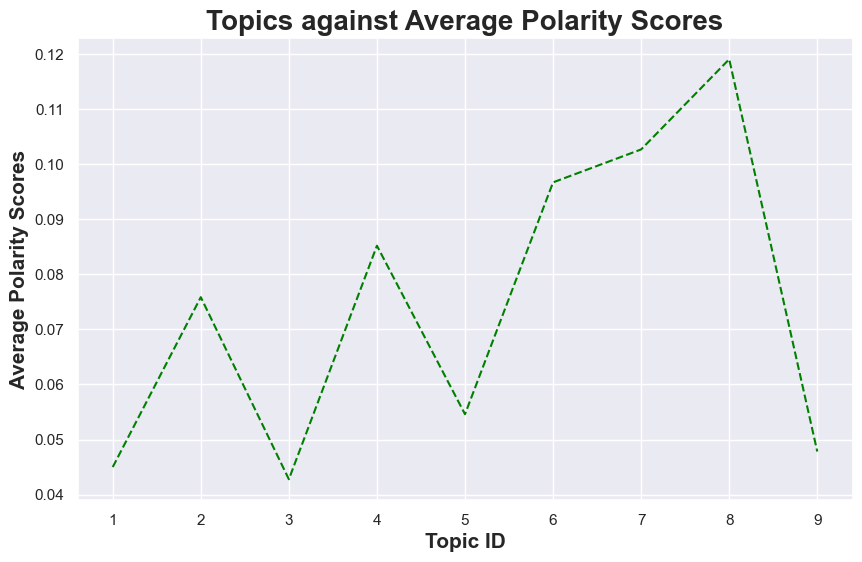

In [241]:
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(x="topic_id", y="polarity", data=topic_sentiments, linestyle='dashed', color='green')

plt.title("Topics against Average Polarity Scores",fontweight='bold', fontsize='20')
plt.xlabel("Topic ID", fontweight='bold', fontsize='15')
plt.ylabel("Average Polarity Scores",fontweight='bold', fontsize='15')
# plt.text(5, 25.5, f"Polarity Score: {round(topic_sentiments['polarity'][5],4)}", fontsize=10, fontweight="bold")
# plt.text(7, 9.5, f"Polarity Score: {round(topic_sentiments['polarity'][7],4)}", fontsize=10, fontweight="bold")
# plt.text(3, 24.1, f"Polarity Score: {round(topic_sentiments['polarity'][3],4)}", fontsize=10, fontweight="bold")
# plt.text(4, 9.7, f"Polarity Score: {round(topic_sentiments['polarity'][4],4)}", fontsize=10, fontweight="bold")
plt.show()

In [289]:
# Visualize with pyLDAvis
from IPython.core.display import HTML
pyLDAvis.enable_notebook(local=True)

vis = gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, "lda_vis.html")
# pyLDAvis.display(vis)

In [291]:
display(HTML('lda_vis.html'))